# Long-term movement monitoring database
## Here is how I work with this data

Using the Waveform Data Base (wfdb) library, I load and work with the Physionet Long-term Movement Monitoring (LTMM) data as follows.

In [39]:
import wfdb
import os

First lets load the database.

In [7]:
dbs_dir = os.path.abspath("../../data/physionet/ltmm/")
dbs = wfdb.io.get_record_list('ltmm')

Now I will go ahead and load a record as an example.

In [40]:
t_min = 60
fps = 200
t_frame = t_min * 60 * fps
dbs_path = os.path.abspath("../../data/physionet/ltmm/%s" % dbs[0])
rec = wfdb.io.rdrecord(dbs_path, sampfrom=0, sampto=t_frame)
rec, rec.sig_name

(<wfdb.io.record.Record at 0x7f4d3637b358>,
 ['v-acceleration',
  'ml-acceleration',
  'ap-acceleration',
  '/s 0 0 -1124 3453 0 yaw-velocity',
  '/s 0 0 -883 -9724 0 pitch-velocity',
  '/s 0 0 634 -26911 0 roll-velocity'])

In [41]:
signal = rec.p_signal
print(signal.shape)

(720000, 6)


And just to give a quick sense of what this looks like.

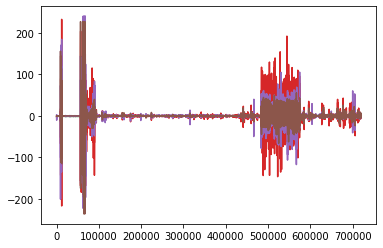

In [15]:
import matplotlib.pyplot as plt
for i in range(6):
    plt.plot(signal[:,i])
plt.show()

Now some functions that will be useful for deploying my model.

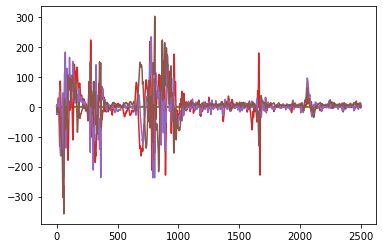

In [45]:
def minutes2frames(t_minutes, fps=100):
    return t_minutes*fps*60

def grab_window(dbs, irec = 0, fstart = 0, fclose = 2500):
    dbs_path = os.path.abspath("../../data/physionet/ltmm/%s" % dbs[irec])
    rec = wfdb.io.rdrecord( dbs_path, 
                            sampfrom=fstart, 
                            sampto=fclose )
    return rec.p_signal, rec.sig_name

def plot_window(dbs, irec = 0, fstart = 0, fclose = 2500,
               acc = True, rot = True):
    clip, head = grab_window(dbs, irec = irec, 
                             fstart = fstart, fclose = fclose )
    c1 = "blue"
    c2 = "green"
    if acc and rot:
        fig, ax1 = plt.subplots()
        c1 = "blue"
        ax1.set_xlabel('time (frames)')
        ax1.set_ylabel('accelerations', color = c1)
        for i in range(3):
            ax1.plot(clip[:,i], label=head[i], color = c1)
        
        ax2 = ax1.twinx()
        ax2.set_ylabel("rotations", color = c2)
        for i in range(3):
            ax2.plot(clip[:,i+3], label=head[i+3], color = c2)

        fig.tight_layout()
    if acc and not rot:
        plt.xlabel('time (frames)')
        plt.ylabel('accelerations', color = c1)
        for i in range(3):
            plt.plot(clip[:,i], label=head[i], color = c1)
            
    if rot and not acc:
        plt.xlabel('time (frames)')
        plt.ylabel('rotations', color = c2)
        for i in range(3):
            plt.plot(clip[:,i+3], label=head[i+3], color = c2)
    
    plt.show()
    plt.clf()

clip, head = grab_window(dbs, irec = 13)
clip.shape
plt.plot(clip)

So now we can get a sense of what a sample frame looks like. Here's another example of what I can do with the `plot_window()` function.

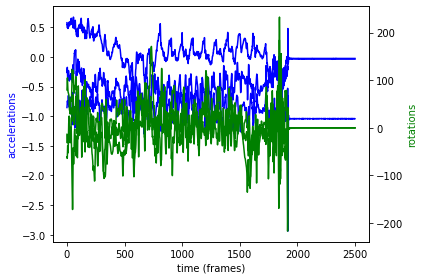

<Figure size 432x288 with 0 Axes>

In [47]:
fstart = 10000
ftotal = 2500
fclose = fstart + ftotal
plot_window(dbs, fstart = fstart, fclose = fclose )

And just a couple more functions to save and load a model.

In [49]:
from tensorflow.keras.models import model_from_json
import h5py
import os
# serialize model to JSON
def save_model(model):
    loc = os.path.abspath("../../models")
    fjson = "%s/%s.json" % (loc, fstr)
    fh5   = "%s/%s.h5" % (loc, fstr)
    model_json = model.to_json()
    with open(fjson, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(fh5)
    print("Saved model to disk")
    
def load_model(fstr = "model"):
    loc = os.path.abspath("../../models")
    fjson = "%s/%s.json" % (loc, fstr)
    fh5   = "%s/%s.h5" % (loc, fstr)
    json_file = open(fjson, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(fh5)
    print("Loaded model from disk")
    return loaded_model

model = load_model(fstr = "model_hybrid_20")

Loaded model from disk


In [50]:
df, header = grab_window(dbs, irec = 0, fstart = 0, fclose = 256)

In [51]:
df.shape

(256, 6)

(256, 6) (512, 6)
(256,) (512,)


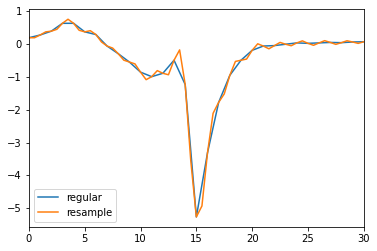

array([[-0.02430932, -0.00709566, -1.05035309,  0.19197293,  2.66644846,
         0.00706453],
       [-0.02239338, -0.00691597, -1.05367   ,  0.19138965,  2.05714311,
        -0.00439768],
       [-0.0214494 , -0.00709566, -1.05905317,  0.27424704,  0.83943748,
        -0.01412905],
       ...,
       [-0.02380142, -0.01067618, -1.0395495 ,  0.01346675, -0.86462658,
         0.0144137 ],
       [-0.02430932, -0.00993393, -1.04165302,  0.06170558, -0.2045688 ,
         0.02119358],
       [-0.0250431 , -0.00818669, -1.04657842,  0.16741755,  1.59773113,
         0.01730309]])

In [52]:
from scipy import signal
import numpy as np
x = np.arange(0,len(df),1)
df2 = signal.resample(df,2*len(df))
print(df.shape, df2.shape)
x2 = np.arange(0,len(df),0.5)
print(x.shape, x2.shape)
plt.plot(x, df[:,3], label="regular")
plt.plot(x2, df2[:,3], label="resample")
plt.xlim([0,30])
plt.legend()
plt.show()
df2

In [101]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

def grab_windows(dbs, irec = 0, start = 0, end = 60, 
                 fps = 100, stride = 200):
    resample = fps / 200
    windows = []
    n_frames = (end - start)*fps
    n_strides = int(n_frames / stride)
    
    for i in range(n_strides):
        _fs = start + i*stride
        _fc = _fs + int(256*resample)
        _df, _head = grab_window(dbs, irec = irec, fstart = _fs, fclose = _fc)
        if resample != 1:
            _df = signal.resample(_df,256)
        windows.append(_df)
    return np.array(windows)
    
def evaluate_windows(dbs, irec = 0, start = 0, end = 60, fps = 100, stride = 256):
    _windows = grab_windows(dbs, irec = irec, 
                            start = start, end = end, 
                            fps = fps, stride = stride)
    results = model.predict(_windows)
#     results[:,0] = results[:,0] * 4
#     return np.argmax(results, axis=1)
    return results

def grab_hours(dbs, irec = 0, hour_start = 0, hour_end = 24):
    results = []
    for i in range(hour_start, hour_end):
        t_start = i * 60*60
        t_end = (i+1) * 60*60
        print("Hour ", i+1)
        results.extend(evaluate_windows(dbs, irec = irec, 
                                        start = t_start, end = t_end))
    return np.array(results)

## Now, let's use these to do some fall classification!

In [97]:
result = grab_hours(dbs, hour_start = 0, hour_end=24, irec=51)

Hour  1
Hour  2
Hour  3
Hour  4
Hour  5
Hour  6
Hour  7
Hour  8
Hour  9
Hour  10
Hour  11
Hour  12
Hour  13
Hour  14
Hour  15
Hour  16
Hour  17
Hour  18
Hour  19
Hour  20
Hour  21
Hour  22
Hour  23
Hour  24


In [157]:
# result = np.array(result)
result = np.array(result)

## Now here is a tunable parameter 
This helps better identify how sensitive I am in my interpretation of the model classification of a stumble event. I am requiring $P(\text{stumble}) > 0.85$.

In [158]:
result

array([[0.4043352 , 0.33457744, 0.26108742],
       [0.3733926 , 0.3463763 , 0.28023103],
       [0.25955442, 0.4058753 , 0.33457032],
       ...,
       [0.5923959 , 0.21729475, 0.19030939],
       [0.5213153 , 0.26656356, 0.21212113],
       [0.6080002 , 0.20682472, 0.18517508]], dtype=float32)

In [163]:
t_factor = len(result) / 24

In [170]:
resultt = np.column_stack((t, result))

Text(0.5, 0, 'time (hour)')

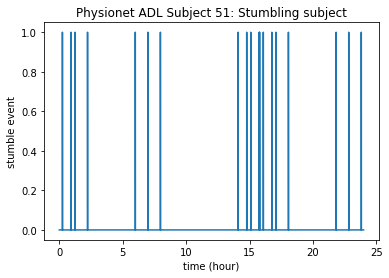

In [178]:
t = np.arange(0,len(result),1) / t_factor
plt.plot(resultt[:,0],(resultt[:,2]>0.8))
plt.title("Physionet ADL Subject 51: Stumbling subject")
plt.ylabel("stumble event")
plt.xlabel("time (hour)")

In [179]:
result2 = grab_hours(dbs, hour_start = 0, hour_end=24, irec=21)

Hour  1
Hour  2
Hour  3
Hour  4
Hour  5
Hour  6
Hour  7
Hour  8
Hour  9
Hour  10
Hour  11
Hour  12
Hour  13
Hour  14
Hour  15
Hour  16
Hour  17
Hour  18
Hour  19
Hour  20
Hour  21
Hour  22
Hour  23
Hour  24


Text(0.5, 0, 'time (hour)')

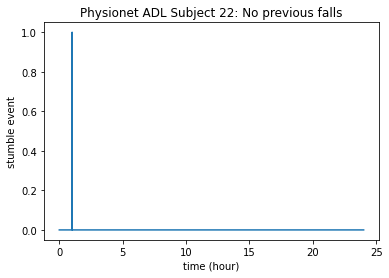

In [192]:
resultt2 = np.column_stack((t, result2))
t = np.arange(0,len(result),1) / t_factor
plt.plot(resultt2[:,0][10:],(resultt2[:,2][10:]>0.6))
plt.title("Physionet ADL Subject 22: No previous falls")
plt.ylabel("stumble event")
plt.xlabel("time (hour)")

1 CO002
Hour  1
Hour  2
Hour  3
Hour  4
Hour  5
Hour  6
Hour  7
Hour  8
Hour  9
Hour  10
Hour  11
Hour  12
Hour  13
Hour  14
Hour  15
Hour  16
Hour  17
Hour  18
Hour  19
Hour  20
Hour  21
Hour  22
Hour  23
Hour  24
Hour  25
Hour  26
Hour  27
Hour  28
Hour  29
Hour  30
Hour  31
Hour  32
Hour  33
Hour  34
Hour  35
Hour  36
Hour  37
Hour  38
Hour  39
Hour  40
Hour  41
Hour  42
Hour  43
Hour  44
Hour  45
Hour  46
Hour  47
Hour  48
Hour  49
Hour  50
Hour  51
Hour  52
Hour  53
Hour  54
Hour  55
Hour  56
Hour  57
Hour  58
Hour  59
Hour  60
Hour  61
Hour  62
Hour  63
Hour  64
Hour  65
Hour  66
Hour  67
Hour  68
Hour  69
Hour  70
Hour  71
Hour  72


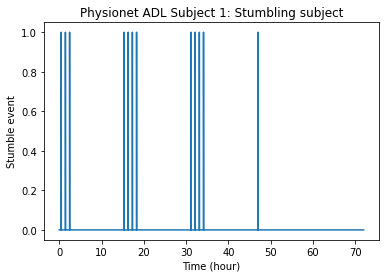

21 CO022
Hour  1
Hour  2
Hour  3
Hour  4
Hour  5
Hour  6
Hour  7
Hour  8
Hour  9
Hour  10
Hour  11
Hour  12
Hour  13
Hour  14
Hour  15
Hour  16
Hour  17
Hour  18
Hour  19
Hour  20
Hour  21
Hour  22
Hour  23
Hour  24
Hour  25
Hour  26
Hour  27
Hour  28
Hour  29
Hour  30
Hour  31
Hour  32
Hour  33
Hour  34
Hour  35
Hour  36
Hour  37
Hour  38
Hour  39
Hour  40
Hour  41
Hour  42
Hour  43
Hour  44
Hour  45
Hour  46
Hour  47
Hour  48
Hour  49
Hour  50
Hour  51
Hour  52
Hour  53
Hour  54
Hour  55
Hour  56
Hour  57
Hour  58
Hour  59
Hour  60
Hour  61
Hour  62
Hour  63
Hour  64
Hour  65
Hour  66
Hour  67
Hour  68
Hour  69
Hour  70
Hour  71
Hour  72


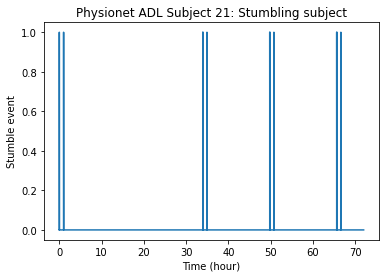

31 CO035
Hour  1
Hour  2
Hour  3
Hour  4
Hour  5
Hour  6
Hour  7
Hour  8
Hour  9
Hour  10
Hour  11
Hour  12
Hour  13
Hour  14
Hour  15
Hour  16
Hour  17
Hour  18
Hour  19
Hour  20
Hour  21
Hour  22
Hour  23
Hour  24
Hour  25
Hour  26
Hour  27
Hour  28
Hour  29
Hour  30
Hour  31
Hour  32
Hour  33
Hour  34
Hour  35
Hour  36
Hour  37
Hour  38
Hour  39
Hour  40
Hour  41
Hour  42
Hour  43
Hour  44
Hour  45
Hour  46
Hour  47
Hour  48
Hour  49
Hour  50
Hour  51
Hour  52
Hour  53
Hour  54
Hour  55
Hour  56
Hour  57
Hour  58
Hour  59
Hour  60
Hour  61
Hour  62
Hour  63
Hour  64
Hour  65
Hour  66
Hour  67
Hour  68
Hour  69
Hour  70
Hour  71
Hour  72


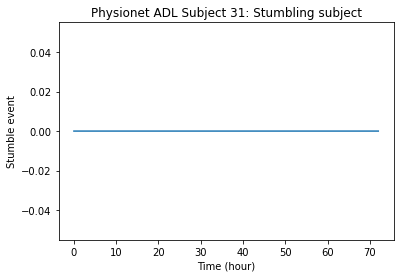

41 FL004
Hour  1
Hour  2
Hour  3
Hour  4
Hour  5
Hour  6
Hour  7
Hour  8
Hour  9
Hour  10
Hour  11
Hour  12
Hour  13
Hour  14
Hour  15
Hour  16
Hour  17
Hour  18
Hour  19
Hour  20
Hour  21
Hour  22
Hour  23
Hour  24
Hour  25
Hour  26
Hour  27
Hour  28
Hour  29
Hour  30
Hour  31
Hour  32
Hour  33
Hour  34
Hour  35
Hour  36
Hour  37
Hour  38
Hour  39
Hour  40
Hour  41
Hour  42
Hour  43
Hour  44
Hour  45
Hour  46
Hour  47
Hour  48
Hour  49
Hour  50
Hour  51
Hour  52
Hour  53
Hour  54
Hour  55
Hour  56
Hour  57
Hour  58
Hour  59
Hour  60
Hour  61
Hour  62
Hour  63
Hour  64
Hour  65
Hour  66
Hour  67
Hour  68
Hour  69
Hour  70
Hour  71
Hour  72


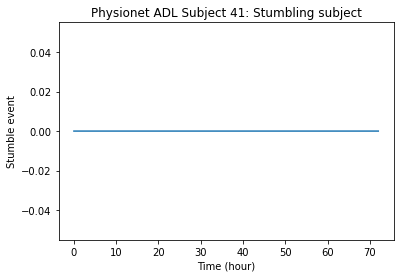

51 FL016
Hour  1
Hour  2
Hour  3
Hour  4
Hour  5
Hour  6
Hour  7
Hour  8
Hour  9
Hour  10
Hour  11
Hour  12
Hour  13
Hour  14
Hour  15
Hour  16
Hour  17
Hour  18
Hour  19
Hour  20
Hour  21
Hour  22
Hour  23
Hour  24
Hour  25
Hour  26
Hour  27
Hour  28
Hour  29
Hour  30
Hour  31
Hour  32
Hour  33
Hour  34
Hour  35
Hour  36
Hour  37
Hour  38
Hour  39
Hour  40
Hour  41
Hour  42
Hour  43
Hour  44
Hour  45
Hour  46
Hour  47
Hour  48
Hour  49
Hour  50
Hour  51
Hour  52
Hour  53
Hour  54
Hour  55
Hour  56
Hour  57
Hour  58
Hour  59
Hour  60
Hour  61
Hour  62
Hour  63
Hour  64
Hour  65
Hour  66
Hour  67
Hour  68
Hour  69
Hour  70
Hour  71
Hour  72


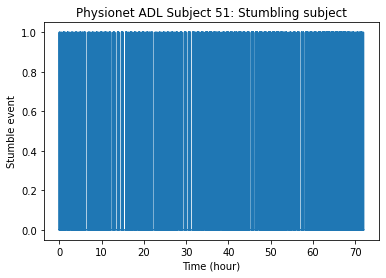

61 FL027
Hour  1
Hour  2
Hour  3
Hour  4
Hour  5
Hour  6
Hour  7
Hour  8
Hour  9
Hour  10
Hour  11
Hour  12
Hour  13
Hour  14
Hour  15
Hour  16
Hour  17
Hour  18
Hour  19
Hour  20
Hour  21
Hour  22
Hour  23
Hour  24
Hour  25
Hour  26
Hour  27
Hour  28
Hour  29
Hour  30
Hour  31
Hour  32
Hour  33
Hour  34
Hour  35
Hour  36
Hour  37
Hour  38
Hour  39
Hour  40
Hour  41
Hour  42
Hour  43
Hour  44
Hour  45
Hour  46
Hour  47
Hour  48
Hour  49
Hour  50
Hour  51
Hour  52
Hour  53
Hour  54
Hour  55
Hour  56
Hour  57
Hour  58
Hour  59
Hour  60
Hour  61
Hour  62
Hour  63
Hour  64
Hour  65
Hour  66
Hour  67
Hour  68
Hour  69
Hour  70
Hour  71
Hour  72


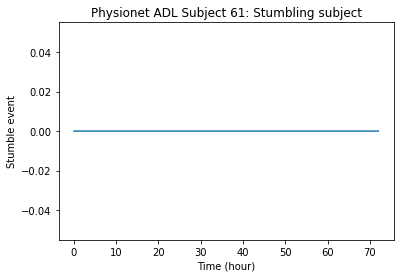

In [196]:
alpha_ss = 0.6
results = {}
for irec in [1,21,31,41,51,61]:
# for irec in [21,31,41,51,61]:
    print(irec, dbs[irec])
    _result = grab_hours(dbs, irec=irec, hour_start=0, hour_end=72)
    t = np.arange(0,len(_result),1) / t_factor
    results[irec] = np.column_stack((t,_result))
    plt.plot(results[irec][:,0],results[irec][:,2] > alpha_ss)
    plt.title("Physionet ADL Subject %i: Stumbling subject" % irec)
    plt.ylabel("Stumble event")
    plt.xlabel("Time (hour)")
    plt.show()

1 CO002


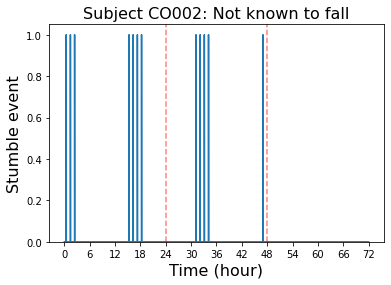

21 CO022


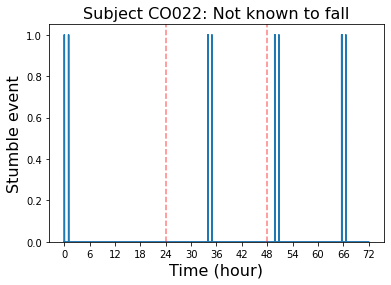

31 CO035


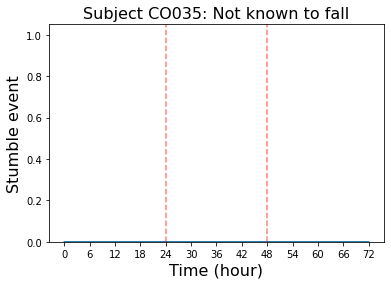

41 FL004


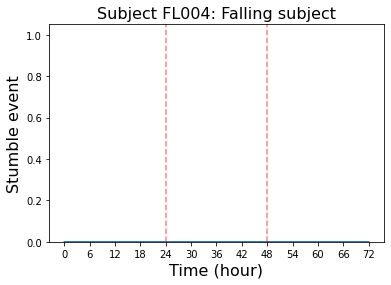

51 FL016


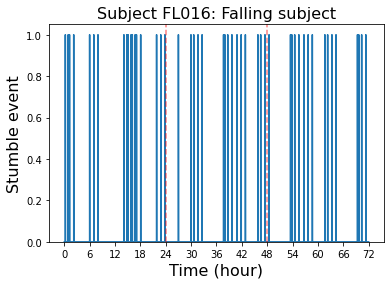

61 FL027


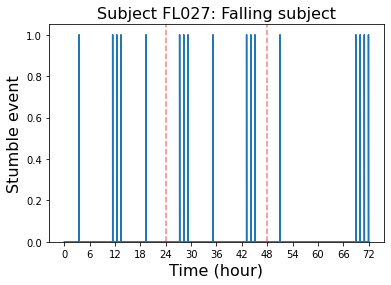

In [216]:
sub_thresh = {1: 0.6,21: 0.6,31: 0.55,41: 0.6, 51: 0.8, 61: 0.5}
sub_type = {'C': "Not known to fall", 'F': "Falling subject"}
for irec in [1,21,31,41,51,61]:
# for irec in [21,31,41,51,61]:
    print(irec, dbs[irec])
    plt.plot(results[irec][:,0],results[irec][:,2] > sub_thresh[irec])
    plt.xticks(np.arange(0,73,6))
    plt.ylim([0,1.05])
    plt.axvline(24,0,1, ls='--', c='r', alpha=0.5)
    plt.axvline(48,0,1, ls='--', c='r', alpha=0.5)
    plt.title("Subject %s: %s" % (dbs[irec], sub_type[dbs[irec][0]]), fontsize="16")
    plt.ylabel("Stumble event", fontsize="16")
    plt.xlabel("Time (hour)", fontsize="16")
    plt.show()

In [ ]:
for k in results.keys():
    results[k] = np.array(results[k])

In [ ]:
for k in results.keys():
    print("%2i %s %3i %3i %4i" % 
          (k, dbs[k],
           len(results[k][results[k] == 1]), 
           len(results[k][results[k] == 2]), 
           len(results[k][results[k] == 0])))

In [ ]:
for k in results.keys():
    print("%2i %s %5.3f %4i" % 
          (k, dbs[k],
           len(results[k][results[k] == 1])/len(results[k][results[k] == 2]), 
           len(results[k][results[k] == 0])))

In [ ]:
for k in results.keys():
    total_time = len(results[k])
    time_day = int(total_time/3)
    print(time_day)
    print("%2i %s" % (k, dbs[k]))
    for i in range(3):
        _res = results[k][i*time_day:(i+1)*time_day]
        print(_res.shape)
        n_prefall = len(_res[_res == 1])
        n_fall = len(_res[_res == 2])
        if n_fall == 0: n_fall = 1
        print("    Day %2i %3i %5.3f" % 
          (i+1, n_prefall, float(n_prefall)/n_fall))

PACE Scores, Falls Year, 6mo, yr almost
CO02  97.50  0, 0, 0
CO12 125.50  1, 1, 1
CO22  98.85  0,0,"more than 1"
CO35  95.69  0,0,0
FL04 104.89  5,2,1
FL16  61.13  6,5,"yes, no number"
FL27  75.00  10,5,0


In [ ]:
plot_window(dbs, irec = 1, fstart = 24*60*60*100, fclose = 27*60*60*100, acc = True, rot = True)


In [ ]:
for i in range(len(dbs)):
    print(dbs[i])
    results = grab_hours(dbs, irec=i, hour_start=24, hour_end=48)
    plt.plot(results)
    plt.show()

In [ ]:
plot_window(dbs, irec = 25, fstart = 0, fclose = 2*3600*100,
            acc = True, rot = True)

In [ ]:
print(dbs[45])
results = grab_hours(dbs, irec=25, hour_start=0, hour_end=24)
plt.plot(results)